# An Investigation into Topics and Sentiments in U.S. Fiction Pre/Post-Civil War

**NAME:** Dylan McDonald

**NET ID:** drm275

## Introduction and Hypothesis

The Civil War was a defining moment in the history of the United States which caused massive societal change as well as large-scale death and destruction in parts of the country. This investigation aims to shed light on how, if at all, this historical event manifested in the language and content of fictional works, offering a unique lens through which to understand the consciousness and mindset of the country at this time.

A central focus of this analysis is the anticipation of a shift in sentiment, particularly a potential increase in negativity during or after the Civil War. I hypothesize that the profound societal changes, destruction, and upheaval wrought by the conflict would be reflected in the sentiments expressed in fictional literature. To gain a nuanced understanding, I plan to group texts by region, based on the main state of each author. This regional approach will allow for us to discern regional variations and identify the section of the country that experienced the most dramatic shift in sentiment.

I hypothesize that the Southern region will exhibit a more pronounced change in sentiment. This expectation is grounded in the historical reality of the South undergoing substantial societal transformations following the defeat of the Confederacy and the devastation wrought by Sherman's campaigns (particularly in GA where a lot of these texts were written).

This research not only offers a compelling exploration of historical fiction but also provides insights into the societal echoes that permeate literature in times of upheaval.


### Imports and Installation of Data


We will start by, of course, importing all necessary dependencies as well as downloading the data

In [154]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Image, display


# Topic Modeling and Sentiment Analysis Imports
import nltk
!pip install nrclex
from nrclex import NRCLex
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
!pip install better_profanity
from better_profanity import profanity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import LatentDirichletAllocation


# Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

# File locations
metadata_file = 'corpus_data.tsv'
zip_file_path = 'us_texts.zip'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall()
    print(f"Successfully extracted contents to dir")
except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully extracted contents to dir


In [10]:
metadata = pd.read_csv(
    metadata_file,
    sep='\t',
    low_memory=False
).set_index('source_id')

metadata['name'] = ''

for index, metadata_row in metadata.iterrows():
    metadata.at[index, 'name'] = metadata_row.name

Now that we have the metadata and can now use the row names to extract the associated texts from the us_texts directory.


Let's look at a sample of text from that directory (I've decided to pick index 27).

In [11]:
text_directory = 'us_texts'
sample_file_name = metadata.iloc[27].name

# Let's look at a sample of this text
sample_text_path = os.path.join(text_directory, sample_file_name)
with open(sample_text_path, 'r', encoding='utf-8') as file:
    sample_content = file.read()

# Now let's just look at the first 1000 characters approximately
print(sample_content[:400])

CHAP. I.
Hiatus valde deflendus, multa desiderantur.
HERE is a great gap. Not a word said about
the travels of the Captain, from the packing up of
Teague, and sending him off to France, until after
the termination of the French revolution, and the
armistice
or convention of Amiens. Though the fact
is, that he had been, all this time, travelling, and
Teague had rejoined him, in the capacity of a
pe


## Data and Methods / Results

**The Data:** The dataset that I will be looking at is a corpus of 1,540 volumes of American fiction that was published between the yeras 1789 and 1875. This text data also comes with a file of metadata related to each file of text data

**Limitations:** The limitations of this dataset, as it relates to my task, is that following a filtering down by time period and region, there are limited texts in some of the categories for drawing any concrete conclusions.

**Methods Employed:** I will be utilizing Topic Modeling, Emotional Analysis, and Overall Sentiment Analysis in order to gain insight into the subjects and attitudes being discussed in the time period in order to compare and contrast across both time and region. I feel as though these methods are most appropriate as they allow me to uncover topics, emotion, and overall sentiment trends within this American fiction corpus. By leveraging these methods, I aim to discern patterns, shifts, and unique characteristics across different time periods and regions, providing a nuanced understanding of how historical events may have influenced the literary landscape.

I've broken this section up into five parts:
*   Preprocessing
*   Topic Modeling
*   Emotional Analysis
*   Sentiment Analysis
*   Discussion of Results






### Preprocessing

Now we will begin to preprocess this data and get it ready for analysis. To do this we will add the text to the metadata column so that we don't need to continuously open and read the files in the other directory.

Then, we will narrow down to the columns of interest to us. Next, we can tokenize, remove special characters, put the words in lower case, filter out stopwords, and lemmatize.

Finally, we will rejoin and put the new string into a new column in metadata called 'text_processed'.

In [14]:
preprocessed_df = metadata
preprocessed_df['text'] = ''

for index, row in preprocessed_df.iterrows():
    file_path = os.path.join('us_texts', row.name)

    # Read and add the content to the 'text' column
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        preprocessed_df.at[index, 'text'] = content

preprocessed_df = preprocessed_df.copy()[['pub_date', 'state_main', 'words', 'text']]

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_df['text_processed'] = ''


for index, row in tqdm(preprocessed_df.iterrows(), total=len(preprocessed_df), desc="Processing documents", unit="document"):
    file_path = os.path.join('us_texts', row.name)

    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Convert to lowercase, tokenize, and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in content.lower().split() if word.isalpha() and word not in stop_words]
        processed_text = ' '.join(tokens)

        preprocessed_df.at[index, 'text_processed'] = processed_text

Processing documents: 100%|██████████| 1540/1540 [03:19<00:00,  7.74document/s]


Now are text is processed and we can take a look at the dataframe that we will be using for the rest of our topic modeling.

In [15]:
topic_modeling_df = preprocessed_df
topic_modeling_df.head()

,pub_date,state_main,words,text,text_processed
source_id,,,,,
eaf001,1841,MA,47541,MONALDI.\nCHAPTER I.\nAmong\nthe students of a...,chapter among student seminary bologna two rem...
eaf002,1831,CT,70010,THE REGICIDES\nWe dig no lands for tyrants but...,regicide dig land tyrant chapter bitter aftern...
eaf003,1838,CT,13547,"The loved, the hated, the adored,\nEach mortal...",together reach ocean prize tale delia knew wou...
eaf004,1839,CT,34309,2\nTHE BRIDE OF FORT EDWARD.\nPART FIRST.\nIND...,bride fort part dialogue scene slope wooded hi...
eaf005,1792,NH,33731,LETTER I.\nOriginal State of the\nForest\n.The...,letter original state forest adventure walter ...


### Topic Modeling

Now that we have our dataframe we can begin topic modeling. To do this I have written two functions: one which will perform the topic modeling and one which will help to visualize


One thing worth noting is that there is some horrific profanity used within the texts contained in this data.

In order to avoid displaying these words when performing topic modeling I've utilized a library called "better-profanity" (https://pypi.org/project/better-profanity/) which will help to censor these instances of profanities.

In [33]:
def perform_topic_modeling(data, title, num_topics=15):
    documents = data['text_processed'].tolist()

    vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english', lowercase=True)
    X = vectorizer.fit_transform(documents)

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    for _ in tqdm(range(X.shape[0]), desc="Fitting LDA", unit="document"):
        lda.partial_fit(X[_:_ + 1, :])

    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words_indices = topic.argsort()[:-10 - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]

        # Censor profanity in top_words using better-profanity
        censored_top_words = [profanity.censor(word) for word in top_words]
        # print(f"Topic {topic_idx + 1}: {', '.join(censored_top_words)}")

    visualize_topics(lda, vectorizer.get_feature_names_out(), title = title)

    return lda

def visualize_topics(lda, feature_names, num_words=10, title=""):
    num_topics = lda.n_components

    num_rows = (num_topics + 2) // 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

    if title:
        plt.suptitle(title, fontsize=16)

    for topic_idx, ax in enumerate(axes.flatten()):
        if topic_idx < num_topics:
            top_words_indices = lda.components_[topic_idx].argsort()[:-num_words - 1:-1]
            top_words = [feature_names[i] for i in top_words_indices]

            censored_top_words = [profanity.censor(word) for word in top_words]

            ax.barh(np.arange(num_words), lda.components_[topic_idx][top_words_indices], align='center')
            ax.set_yticks(np.arange(num_words))
            ax.set_yticklabels(censored_top_words, fontsize=8)
            ax.invert_yaxis()
            ax.set_title(f'Topic {topic_idx + 1}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return



In order to perform our analysis in a relevant manner, we need to split the data into texts published before and after the start of the Civil War. We will use 1860 (as opposed to the true date of April 12th 1861) as this date since the change in sentiment is likely a gradual shift.

In [34]:
# Split into pre-1860 and post-1860 dataframes
pre_1860_df = topic_modeling_df[topic_modeling_df['pub_date'] < 1860]
post_1860_df = topic_modeling_df[topic_modeling_df['pub_date'] >= 1860]

Now that we have these dataframes let's look at the topic modeling for the full dataset, before 1860, and after 1860

Topic Modeling for Full Dataset


Fitting LDA: 100%|██████████| 1540/1540 [00:37<00:00, 41.40document/s]


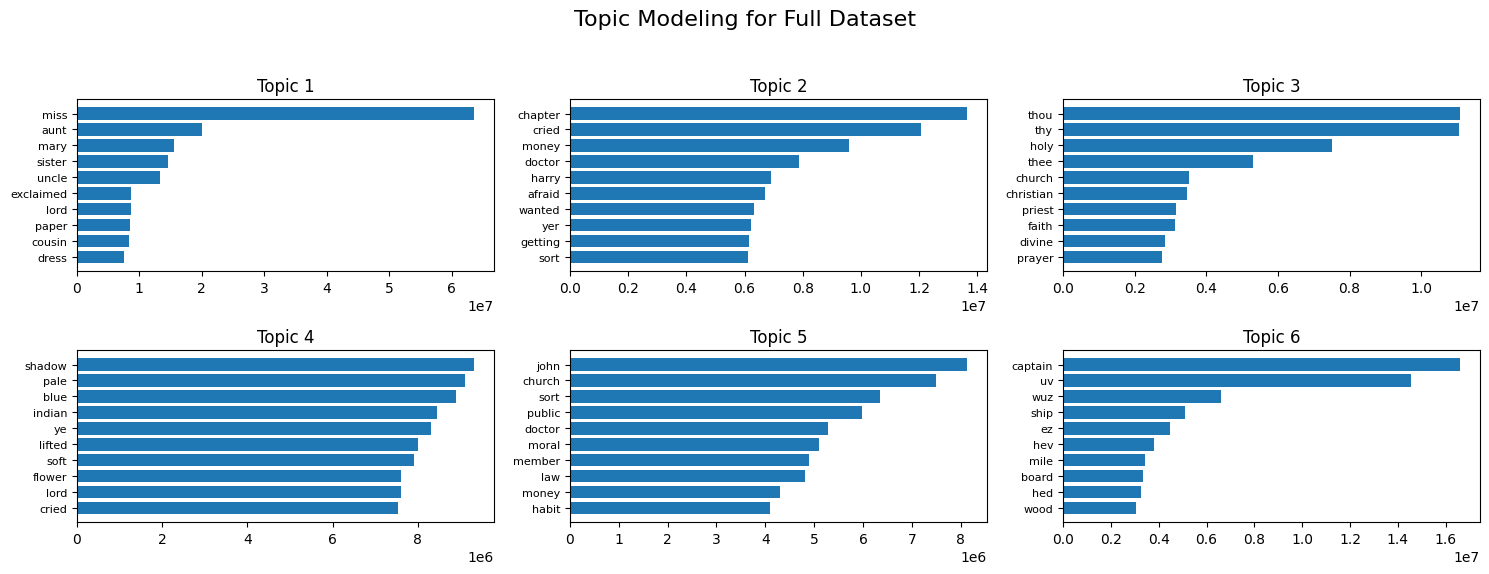

In [35]:
# Perform topic modeling for full dataset
print("Topic Modeling for Full Dataset")
all_tm = perform_topic_modeling(topic_modeling_df, "Topic Modeling for Full Dataset", num_topics = 6)

It's very clear from these topics that these texts are filled with religious themes. This is especially clear in Topic 3. Also, worth noting is an emphasis on family such as in Topic 1.

Let's now perform the topic modeling for pre and post 1860 to see if there is a distinction to be made.

Topic Modeling for Pre-1860:


Fitting LDA: 100%|██████████| 943/943 [00:17<00:00, 52.52document/s]


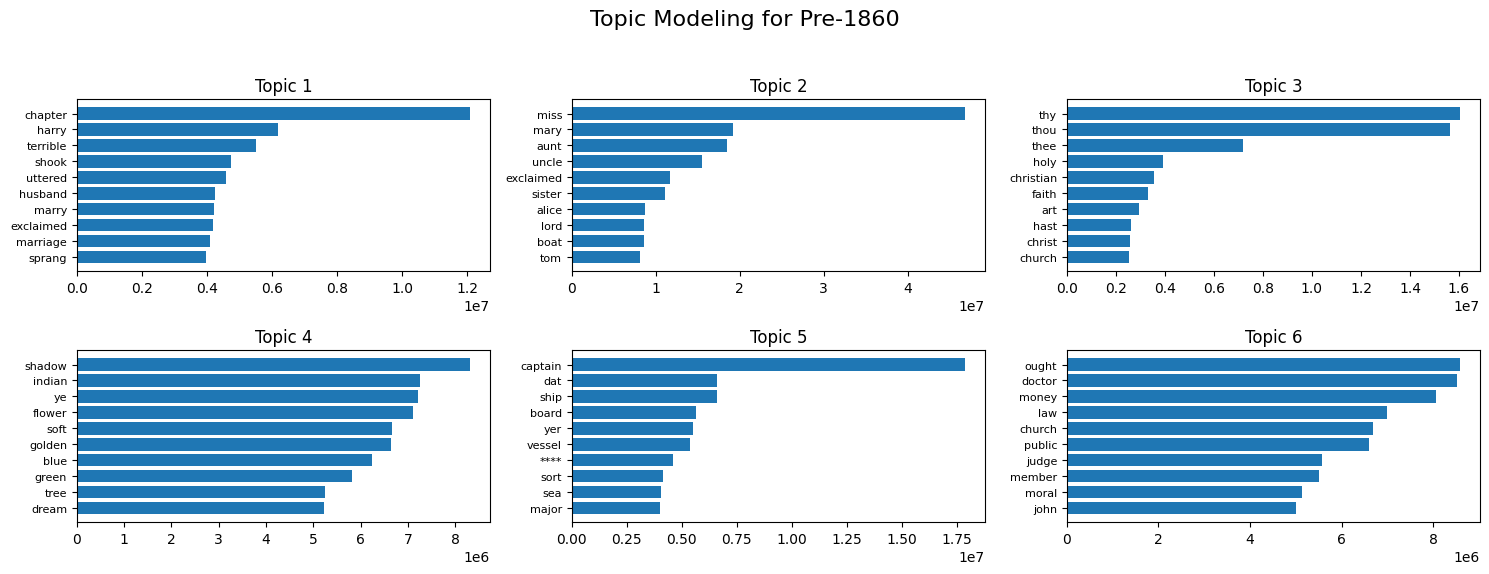

In [37]:
# Perform topic modeling for pre-1860 data
print("Topic Modeling for Pre-1860:")
pre_1860_tm = perform_topic_modeling(pre_1860_df, "Topic Modeling for Pre-1860", num_topics = 6)

Topic Modeling for Post-1860:


Fitting LDA: 100%|██████████| 597/597 [00:09<00:00, 60.08document/s]


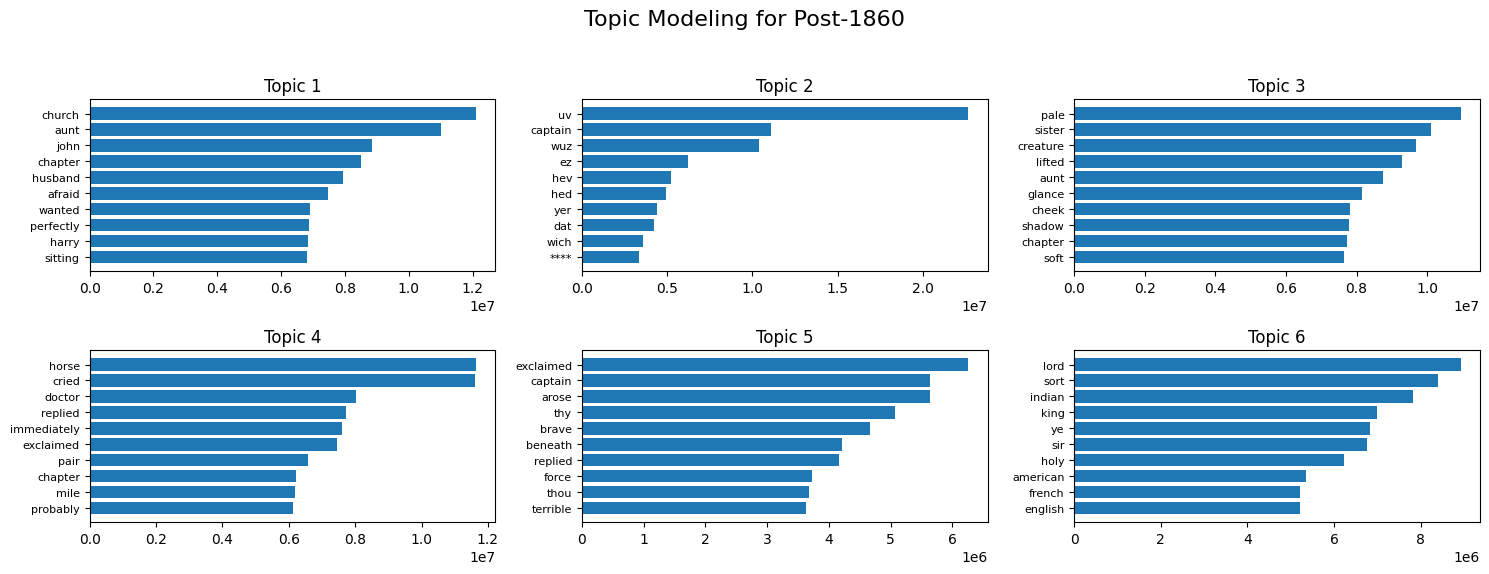

In [38]:
# Perform topic modeling for post-1860 data
print("Topic Modeling for Post-1860:")
post_1860_tm = perform_topic_modeling(post_1860_df, title = "Topic Modeling for Post-1860", num_topics = 6)

Pre-1860 does have the same family and relgious themes that existed across the whole corpus. But, based on these results, post-1860 doesn't have nearly the same amount of discussion about religion.

Additionally, post-1860 does seem to mention more about terms that could be associated with war and more negative terms in general. This is shown primarily in Topics 4, 5, and 6 which contain words like 'horse', 'captain', 'terrible', 'cried', 'etc'.

Now that we see that there is some difference between these two times, let's focus in on our hypothesis. Which was that there would be a noticable difference in the South especially.

In order to see if this is true we need to create a mapping of states to a particular region of the country. I've done that below with a state_to_region dictionary.

In [25]:
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West', 'CO': 'West', 'CT': 'Northeast', 'DE': 'Northeast', 'FL': 'South',
    'GA': 'South', 'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'KY': 'South', 'LA': 'South',
    'ME': 'Northeast', 'MD': 'Northeast', 'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest',
    'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast', 'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest', 'OK': 'South',
    'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West', 'VT': 'Northeast',
    'VA': 'South', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest', 'WY': 'West'
}

south_before_1860 = topic_modeling_df[(topic_modeling_df['state_main'].map(state_to_region) == 'South') & (topic_modeling_df['pub_date'] < 1860)]
south_after_1860 = topic_modeling_df[(topic_modeling_df['state_main'].map(state_to_region) == 'South') & (topic_modeling_df['pub_date'] >= 1860)]
north_before_1860 = topic_modeling_df[(topic_modeling_df['state_main'].map(state_to_region) == 'Northeast') & (topic_modeling_df['pub_date'] < 1860)]
north_after_1860 = topic_modeling_df[(topic_modeling_df['state_main'].map(state_to_region) == 'Northeast') & (topic_modeling_df['pub_date'] >= 1860)]


Now that we have our state to region mapping into dataframes we can look at the topic modeling for the South before and after 1860.

Topic Modeling for the South Pre-1860:


Fitting LDA: 100%|██████████| 142/142 [00:01<00:00, 84.37document/s]


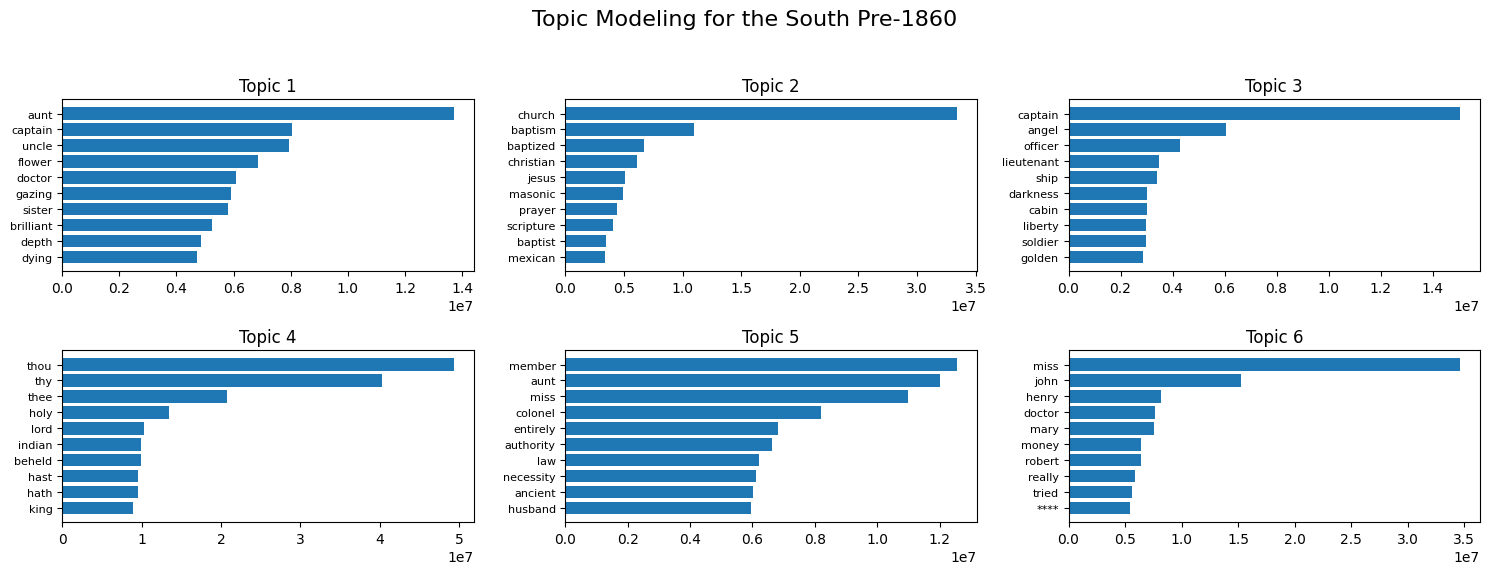

In [39]:
# Perform topic modeling for south pre-1860 data
print("Topic Modeling for the South Pre-1860:")
south_pre_1860_tm = perform_topic_modeling(south_before_1860, title = "Topic Modeling for the South Pre-1860", num_topics = 6)

The South pre-1860 contains a lot of religious words, such as 'church', 'baptism', 'christian', and all of Topic 2.

This is consistent with what we saw in the overall dataset.

Topic Modeling for the South Post-1860:


Fitting LDA: 100%|██████████| 30/30 [00:00<00:00, 45.31document/s]


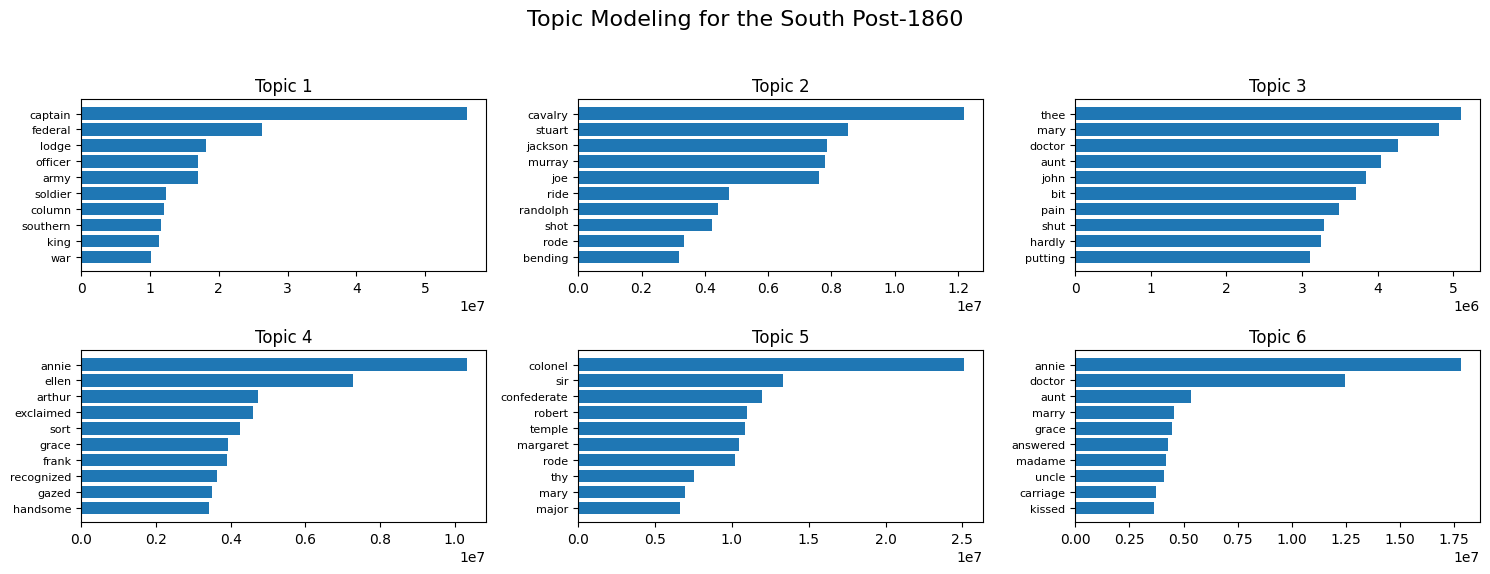

In [40]:
# Perform topic modeling for south post-1860 data
print("Topic Modeling for the South Post-1860:")
south_post_1860_tm = perform_topic_modeling(south_after_1860, title = "Topic Modeling for the South Post-1860", num_topics = 6)

The topics in the South post-1860 seem to have shifted more towards words associated with war and violence.

This is best seen through Topic 1, 2, 3, and 5 which contains words such as 'war', 'federal', 'confederate', 'calvalry', 'pain', 'colonel', and 'shot'.

However, this dataset is small (only 30 documents for the South post-1860), nevertheless within those documents it is clear that there was a shift to more war-based topics following the Civil War...

Additionally, while just discussing war-based topics isn't necessarily the same as containing a more negative emotion and/or sentiment, it is does indicate that these topics are being explored more in literature following the war. It isn't hard to imagine then that these topics are being viewed in a more negative lense following the death and destruction brought on by the war. But, rather than make that assumption, let's see if it can be shown through emotional analysis and/or an overall sentiment analysis.

### Emotional Analysis

In order to perform emotional analysis I will be using the NRC lexicon which will provide scores for the following emotions: joy, positive, anticipation, sadness, surprise, negative, anger, disgust, trust, fear

Once again I passed the dataframes with the data for the South before and after 1860 into the function below which will calculate the emotion scores for all 10 of those emotions.

In [59]:
def calculate_emotion_scores(text):
    nrc_lex = NRCLex(text)
    return [nrc_lex.raw_emotion_scores[emotion] for emotion in emotions]


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [63]:
south_before_1860 = south_before_1860.copy()
south_after_1860 = south_after_1860.copy()

emotions = ['joy', 'positive', 'anticipation', 'sadness', 'surprise', 'negative', 'anger', 'disgust', 'trust', 'fear']
for emotion in emotions:
    south_before_1860[emotion] = 0.0
    south_after_1860[emotion] = 0.0

In [74]:
# South Before 1860
for index, row in tqdm(south_before_1860.iterrows(), total=len(south_before_1860), desc="Calculating emotion scores", unit="document"):
    processed_text = row['text_processed']
    emotion_scores = calculate_emotion_scores(processed_text)

    for i, emotion in enumerate(emotions):
        south_before_1860.at[index, emotion] = emotion_scores[i]

# South After 1860
for index, row in tqdm(south_after_1860.iterrows(), total=len(south_after_1860), desc="Calculating emotion scores", unit="document"):
    processed_text = row['text_processed']
    emotion_scores = calculate_emotion_scores(processed_text)

    for i, emotion in enumerate(emotions):
        south_after_1860.at[index, emotion] = emotion_scores[i]

Calculating emotion scores: 100%|██████████| 30/30 [00:10<00:00,  2.92document/s]


Now that the emotion scores have been calculated, let's plot this in a heatmap to determine how strong each emotion is.

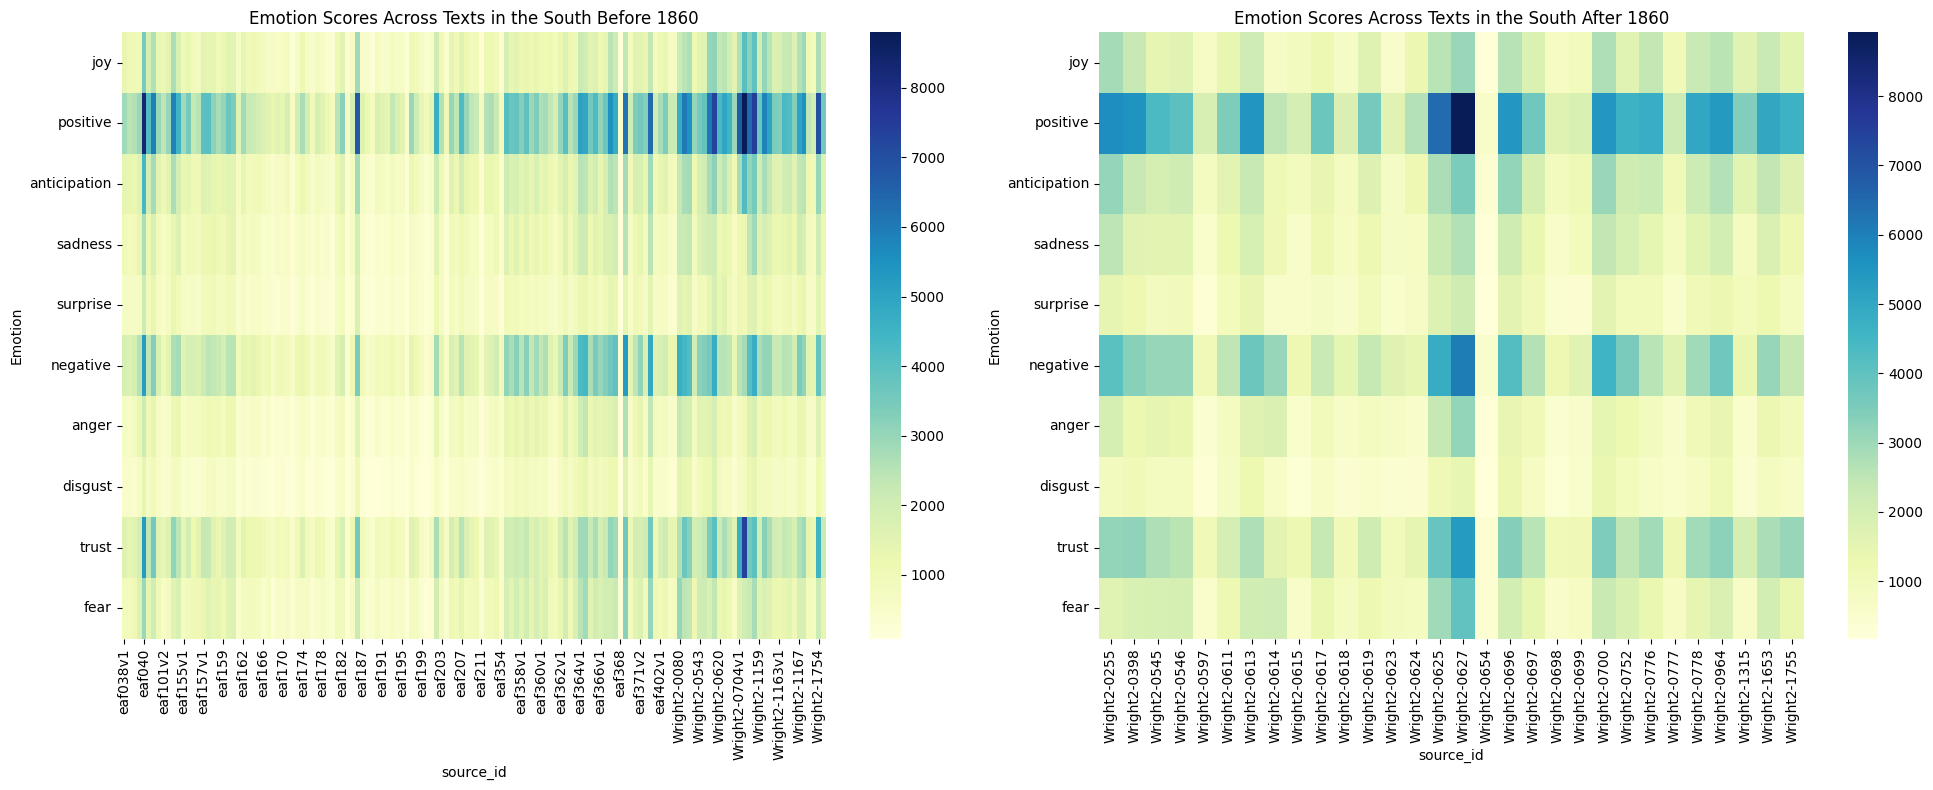

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot for South Before 1860
sns.heatmap(south_before_1860[emotions].T, cmap="YlGnBu", annot=False, ax=axs[0])
axs[0].set_title('Emotion Scores Across Texts in the South Before 1860')
axs[0].set_xlabel('source_id')
axs[0].set_ylabel('Emotion')

# Plot for South After 1860
sns.heatmap(south_after_1860[emotions].T, cmap="YlGnBu", annot=False, ax=axs[1])
axs[1].set_title('Emotion Scores Across Texts in the South After 1860')
axs[1].set_xlabel('source_id')
axs[1].set_ylabel('Emotion')

plt.tight_layout()
plt.show()


Based on this heatmap we can get a look at some of the most prevelant emotions before and after 1860 in the South. One thing worth mentioning is the consistent three bands that appear across both in postiive, negative, and trust.

However, it does appear that the percentage of dark negative bands is higher which is consistent with our thoughts on the observations made after topic modeling earlier.

Also, although it is faint, there does appear to be a slight increase across anger, anticipation, and fear after 1860. This could be seen as evidence in support of our hypothesis.

Let's now continue on with the sentiment analysis

### Sentiment Analysis

Next I want to use TextBlob to look at just the overall sentiment of these texts by region before and after the start of the Civil War to note any changes that may be observed using this library as opposed to the whole emotional analysis done previously.

For this, I did decide to reprocess the text files simply because I wanted to dropout words based on their prevelance in documents in addition to just filtering out the stopwords to see if that had an effect on the results.

Because of this I had to create 2 new preprocessing functions, one for just preprocessing (tokenization, lemmatizing, etc.) and one for filtering out just my selected features (occurs in more than 5 documents and less than 90% of the documents).

In [122]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word.isalpha()]

    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

def preprocess_and_filter_documents(text_directory, metadata_subset, min_df=5, max_df=0.9):
    document_paths = [os.path.join(text_directory, file_name) for file_name in metadata_subset['name']]

    preprocessed_documents = []
    for document_path in tqdm(document_paths, desc="Processing documents", unit="document"):
        with open(document_path, 'r', encoding='utf-8') as file:
            content = file.read()
            preprocessed_content = preprocess_text(content)
            preprocessed_documents.append(preprocessed_content)

    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(preprocessed_documents)

    feature_names = vectorizer.get_feature_names_out()

    filtered_features_list = []
    for i in tqdm(range(X.shape[0]), desc="Calculating selected features", unit="document"):
        selected_features = [feature_names[j] for j in range(X.shape[1]) if X[i, j] > 0]
        filtered_features_list.append(selected_features)

    metadata_subset['filtered_features'] = filtered_features_list

    return metadata_subset


In [123]:
metadata = metadata.copy()
metadata = preprocess_and_filter_documents('us_texts', metadata)

Calculating selected features: 100%|██████████| 1540/1540 [49:30<00:00,  1.93s/document]


In [124]:
features_df = metadata

In [135]:
def get_sentiment_score(features):
    text = ' '.join(features)
    blob = TextBlob(text)
    # blob = TextBlob(features)
    return blob.sentiment.polarity

# features_df = topic_modeling_df.copy()
tqdm.pandas(desc="Calculating sentiment scores")
features_df['sentiment_score'] = features_df['filtered_features'].progress_apply(lambda x: get_sentiment_score(x))

Calculating sentiment scores: 100%|██████████| 1540/1540 [00:42<00:00, 36.18it/s]


In [137]:
features_df[['pub_date', 'state_main','sentiment_score']].sort_values('sentiment_score').head()

,pub_date,state_main,sentiment_score
source_id,,,
Wright2-0198,1852,NaN,-0.068082
Wright2-0448,1860,NaN,-0.065631
eaf028v3,1799,PA,-0.044143
Wright2-0180,1860,NaN,-0.041588
Wright2-0893,1857,NaN,-0.040562


Now we have values for the sentiment score via TextBlob show above. We can now work on plotting these in a meaningful manner. Let's first create an average based on region and plot in a histogram

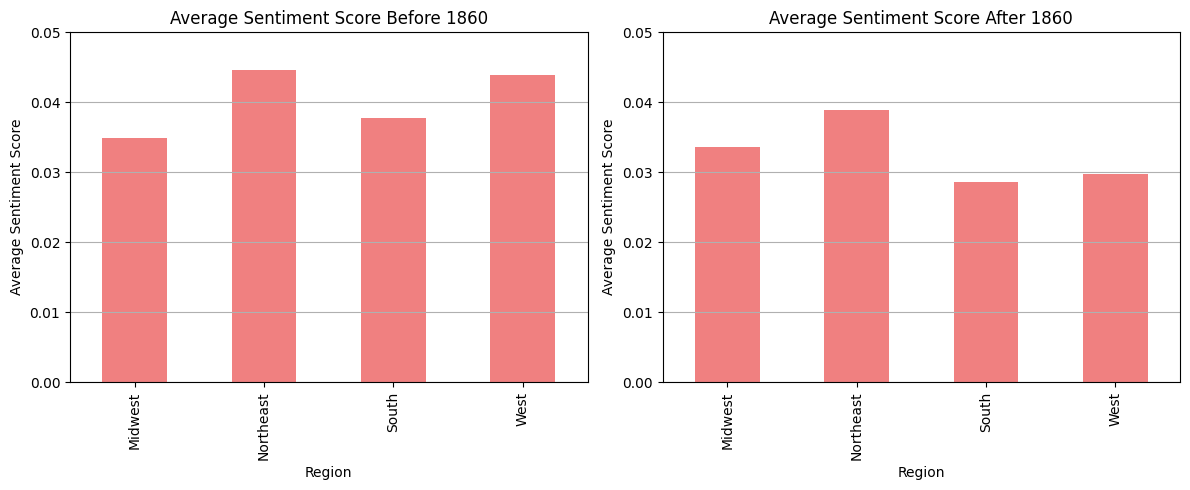

In [139]:
filtered_df = features_df.dropna(subset=['state_main'])

# Filter data before and after 1860
before_1860 = filtered_df[filtered_df['pub_date'] < 1860]
after_1860 = filtered_df[filtered_df['pub_date'] >= 1860]

# Group by state and calculate the average sentiment score in each state
authors_by_state_before = before_1860.groupby('state_main')['sentiment_score'].mean().reset_index(name='avg_sentiment_score_state')
authors_by_state_after = after_1860.groupby('state_main')['sentiment_score'].mean().reset_index(name='avg_sentiment_score_state')

# Map to region
state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West', 'CO': 'West', 'CT': 'Northeast', 'DE': 'Northeast', 'FL': 'South',
    'GA': 'South', 'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'KY': 'South', 'LA': 'South',
    'ME': 'Northeast', 'MD': 'Northeast', 'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest', 'MT': 'West', 'NE': 'Midwest',
    'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast', 'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest', 'OK': 'South',
    'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South', 'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West', 'VT': 'Northeast',
    'VA': 'Northeast', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest', 'WY': 'West'
}

authors_by_state_before['Region'] = authors_by_state_before['state_main'].map(state_to_region)
authors_by_state_after['Region'] = authors_by_state_after['state_main'].map(state_to_region)

average_sentiment_by_region_before = authors_by_state_before.groupby('Region')['avg_sentiment_score_state'].mean()
average_sentiment_by_region_after = authors_by_state_after.groupby('Region')['avg_sentiment_score_state'].mean()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

average_sentiment_by_region_before.sort_index().plot(kind='bar', color='lightcoral', ax=axes[0])
axes[0].set_title('Average Sentiment Score Before 1860')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].set_ylim(0, 0.05)
axes[0].grid(axis='y')

average_sentiment_by_region_after.sort_index().plot(kind='bar', color='lightcoral', ax=axes[1])
axes[1].set_title('Average Sentiment Score After 1860')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Average Sentiment Score')
axes[1].set_ylim(0, 0.05)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


From here we can see that the overall sentiment across all regions appeared to go down post-1860. Interestingly enough, the largest observed decrease looks to be in the West as opposed to the South.

Let's continue with a plot over time to see if there is any information about trends in sentiment over time

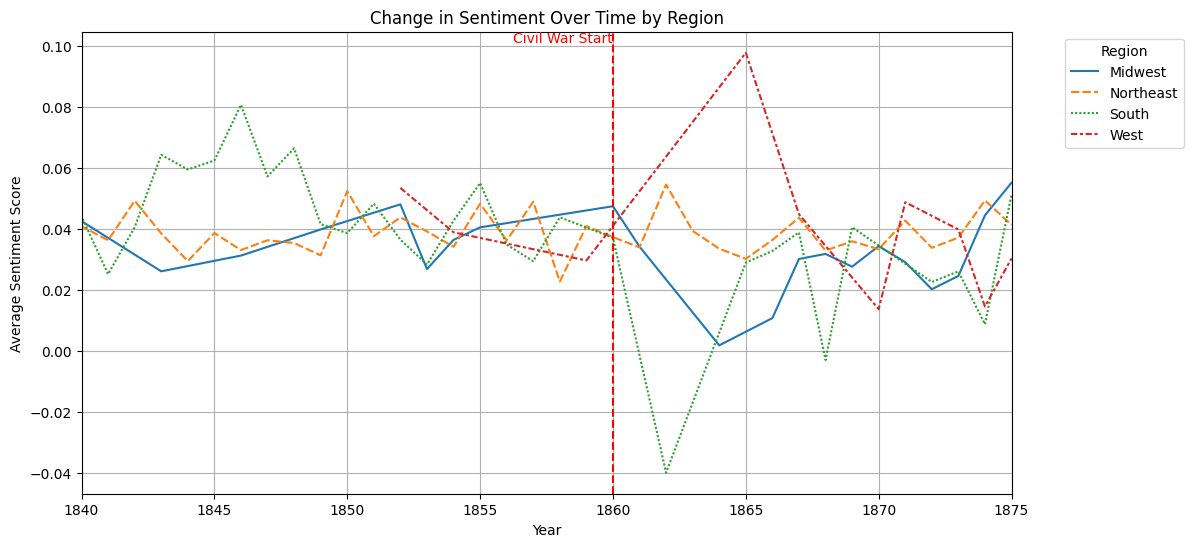

In [148]:
filtered_df = features_df.copy().dropna(subset=['state_main'])


filtered_df['Region'] = filtered_df['state_main'].map(state_to_region)
filtered_df['Region'] = filtered_df['state_main'].map(state_to_region)


authors_by_region = filtered_df.groupby(['pub_date', 'Region'])['sentiment_score'].mean().reset_index(name='avg_sentiment_score_region')
pivot_table = authors_by_region.pivot_table(index='pub_date', columns='Region', values='avg_sentiment_score_region')


plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_table)

plt.title('Change in Sentiment Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.axvline(x=1860, color='red', linestyle='--', label='Civil War Start')
plt.text(1860, plt.ylim()[1], 'Civil War Start', rotation=0, verticalalignment='top', horizontalalignment='right', color='red')


plt.xlim(left=1840, right=1875)
plt.show()


This graph is also pretty telling in regards to our hypothesis. We can see here that there is a sharp decrease in sentiment in the period directly following the Civil War. This is in contrast to the South in the 1840s during which the sentiment was rather positive, in comparison


One thing that is interesting to note and I would be interested in exploring in the future is the sharp increase in the West following that same period. One obvious reason is a limited dataset in the West for this time period. An additional (more creative) explanation could be that the West was seen as a new frontier that people traveled to in hopes of bettering their lives. Perhaps this idea is reflected in the literature that came out of the region during this time period. This is something I would be interested in researching at a deeper level in the future.

### Discussion of Results

The results from employing the methods of topic modeling, emotion analysis, and sentiment analysis indicate a change in Southern fiction following the start of the Civil War around 1860.

This is exhibited in the topics being discussed pre- and post-1860 as shown in the charts generated earlier which I have repasted down below.

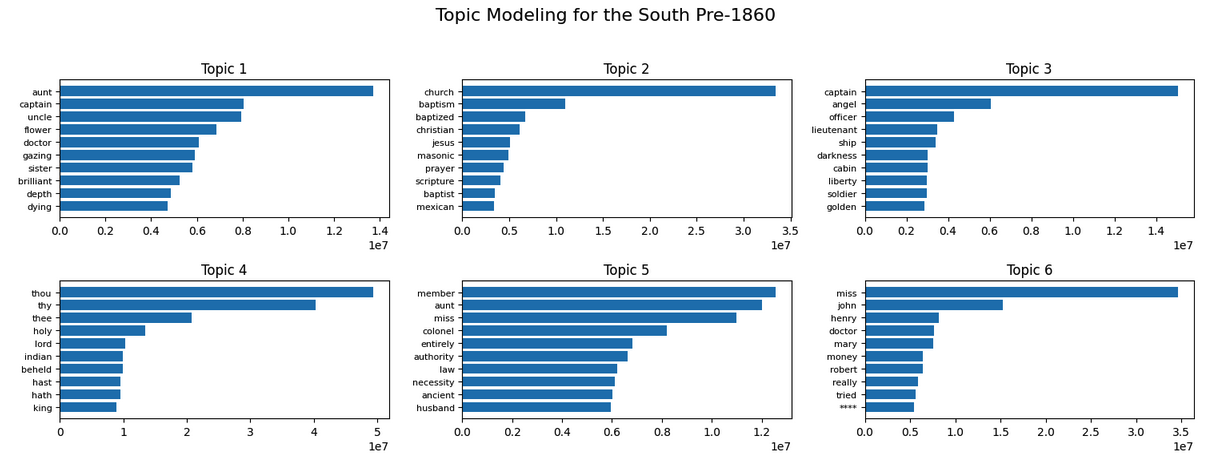

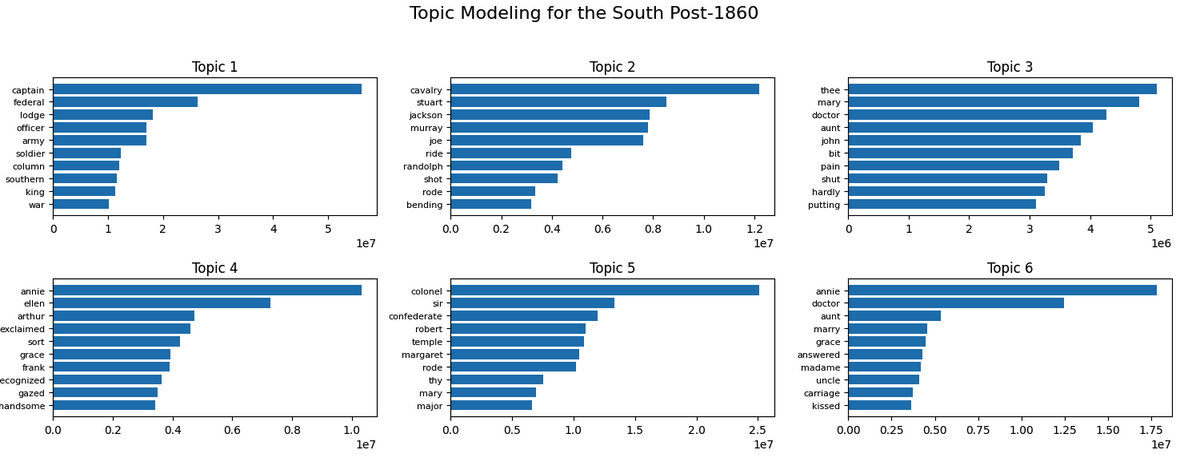

In [153]:
image_path_1 = '/content/tm_south_b1860.png'
image_path_2 = '/content/tm_south_a1860.png'

display(Image(filename=image_path_1))
display(Image(filename=image_path_2))

Additionally, this was shown through the change in strength of each emotion shown through the emotional analysis done on the Southern literature. In particular, there was a slight increase in negative emotion as well as anticipation, anger, and fear in teh texts published after 1860.

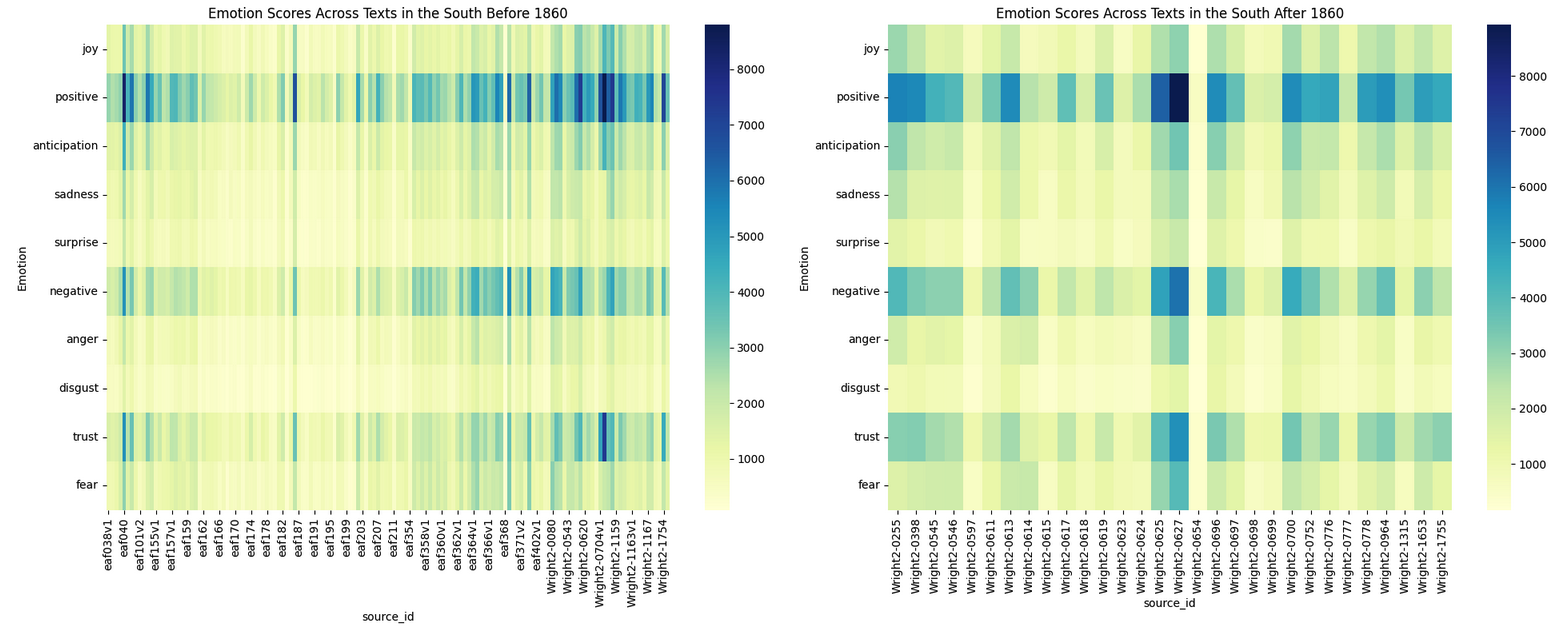

In [155]:
image_path_3 = '/content/emotion_score.png'

display(Image(filename=image_path_3))

Finally, this was shown through the TextBlob overall sentiment polarity analysis which shows a decrease in average sentiment in the South which indicates either an increase in negative sentiment or a decrease in positive sentiment.

However, the line plot in the second figure shown below illustrates that this decrease in average sentiment was more likely due to an increase in negative sentiment due to the points on that line plot over time.

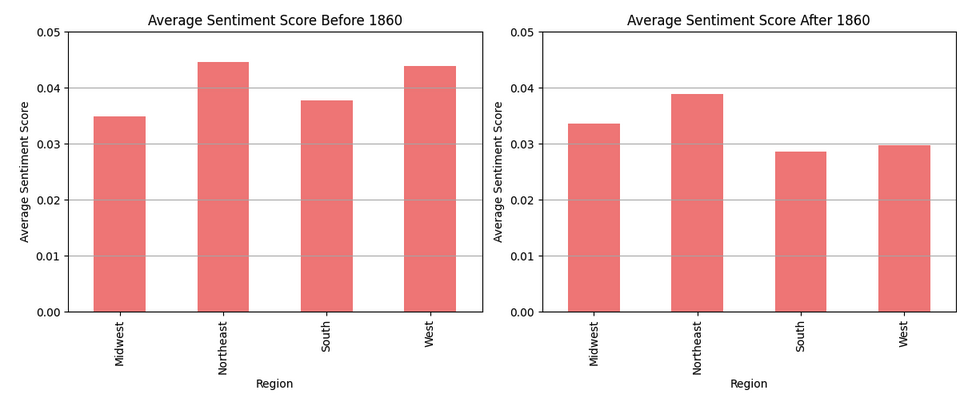

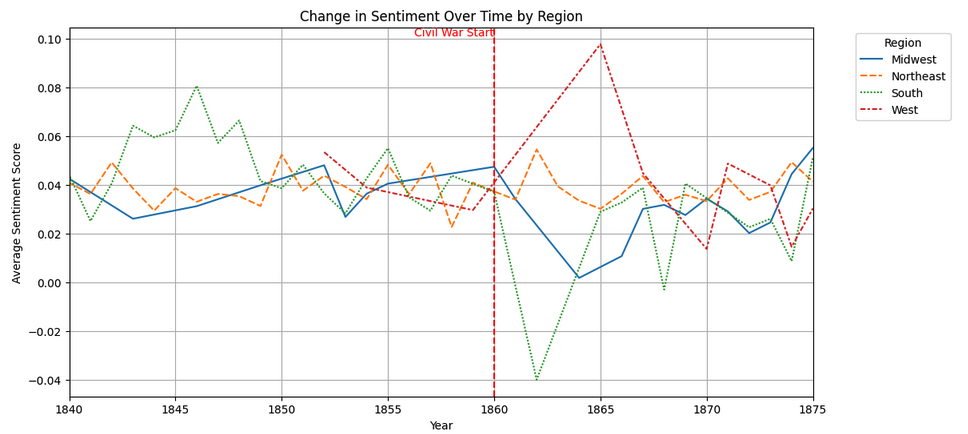

In [156]:
image_path_5 = '/content/sentiment_by_region.png'
image_path_6 = '/content/sentiment_over_time.png'

display(Image(filename=image_path_5))
display(Image(filename=image_path_6))

## Overall Discussion and Conclusionn

Overall, I would conclude that these results loosely support my hypothesis. I believe this to be the case due to the evidence that was found given the dataset, however, this might not be the best dataset for these goals.

What I mean by that is that because I split by region and then time period, I was left with only 30 or so texts to be analyzed by post-1860 in the South. While it may be the case that these texts are representative of the overall sentiment at the time, it is impossible to come to that conclusion with any degree of certainty due to the small sample size.

That was definitely the main limitation within this study. One way in which this could be improved in the future would be to have a larger sample of texts for analysis. This would improve my ability to draw conclusions and my confidence that those conlcusions are representative. However, this may not be possible as I know this is one of the most, if not the most, expansive dataset of American fiction during the 19th century.

One way to modify this study to address that limitation would be to look at different conflicts during the 20th century for which there might be more data (such as before and after WWI, WWII, Vietnam War, etc.) and study the ways in which historical events, in general, are responsible for shaping fictional literature of the time period. If a connection can be made for other conflicts, it is likely that one would exist for the Civil War as well.

Finally, this project gave me a great understanding of the process of constructing research papers in this field and was a great way for me to explore my love for history and data.